In [1]:
from instruction_reader import InstructionReader
from parse import parse_sexprs
import random

import tensorflow.compat.v1 as tf
import os
import pdb
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from tf_optimizer import TfOptimizer
from parse import parse_sexprs
from instruction_reader import InstructionReader

from util_graph_gen import *
from graph_generator import *


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
tf.disable_v2_behavior()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import argparse
import pdb

from builder import build
from util import DEFAULTS
import copy

In [2]:
# Parse arguments
parser = argparse.ArgumentParser(description='Arguments for building a model that satisfies a set of geometry constraints')

# General arguments
parser.add_argument('--problem', '-p', action='store', type=str, help='Name of the file defining the set of constraints')
parser.add_argument('--dir', '-d', action='store', type=str, help='Directory containing problem files.')
parser.add_argument('--regularize_points', action='store', dest='regularize_points', type=float, default=DEFAULTS["regularize_points"])
parser.add_argument('--make_distinct', action='store', dest='make_distinct', type=float, default=DEFAULTS["make_distinct"])
parser.add_argument('--distinct_prob', action='store', dest='distinct_prob', type=float, default=DEFAULTS["distinct_prob"])
parser.add_argument('--min_dist', action='store', dest='min_dist', type=float, default=DEFAULTS["min_dist"])
parser.add_argument('--ndg_loss', action='store', dest='ndg_loss', type=float, default=DEFAULTS["ndg_loss"])

parser.add_argument('--n_models', action='store', dest='n_models', type=int, default=DEFAULTS['n_models'])
parser.add_argument('--n_tries', action='store', dest='n_tries', type=int, default=DEFAULTS['n_tries'])
parser.add_argument('--n_inits', action='store', dest='n_inits', type=int, default=DEFAULTS['n_inits'])
parser.add_argument('--verbosity', action='store', dest='verbosity', type=int, default=DEFAULTS['verbosity'])
parser.add_argument('--enforce_goals', dest='enforce_goals', action='store_true')
parser.add_argument('--plot_freq', action='store', dest='plot_freq', type=int, default=DEFAULTS['plot_freq'])
parser.add_argument('--loss_freq', action='store', dest='loss_freq', type=int, default=DEFAULTS['loss_freq'])
parser.add_argument('--losses_freq', action='store', dest='losses_freq', type=int, default=DEFAULTS['losses_freq'])

parser.add_argument('--unnamed_objects', dest='unnamed_objects', action='store_true')
parser.add_argument('--no_unnamed_objects', dest='unnamed_objects', action='store_false')
parser.set_defaults(unnamed_objects=True)

# Tensorflow arguments
parser.add_argument('--learning_rate', action='store', dest='learning_rate', type=float, default=DEFAULTS["learning_rate"])
parser.add_argument('--decay_steps', action='store', dest='decay_steps', type=float, default=DEFAULTS["decay_steps"])
parser.add_argument('--decay_rate', action='store', dest='decay_rate', type=float, default=DEFAULTS["decay_rate"])
parser.add_argument('--n_iterations', action='store', dest='n_iterations', type=int, default=DEFAULTS["n_iterations"])
parser.add_argument('--eps', action='store', dest='eps', type=float, default=DEFAULTS["eps"])

parser.add_argument('--experiment', dest='experiment', action='store_true')

parser.add_argument("--f", type=str, default='abc.def'),

args = parser.parse_args()
args = vars(args)


In [3]:
args['enforce_goals'] = True

In [12]:
from importlib import reload

import util_graph_gen
reload(util_graph_gen)
from util_graph_gen import *

import graph_generator
reload(graph_generator)
from graph_generator import *

Processing instructions...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing instructions...: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3) triangle ()


Found 1 models


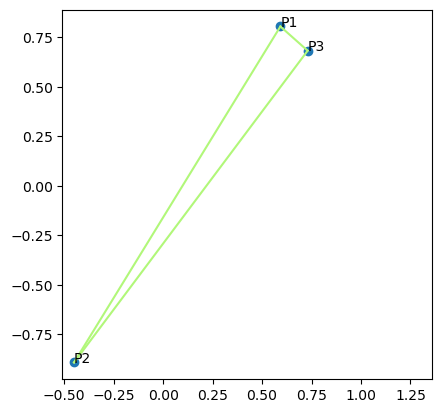

Processing instructions...:   0%|          | 0/2 [00:00<?, ?it/s]

######################## Lines drawn above ########################
['(param (P1 P2 P3) triangle )']

INPUT INSTRUCTIONS:
sample (P1 P2 P3) triangle ()
define P4 ((amidp-same P3 P2 P1))


Processing instructions...: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]




Found 1 models


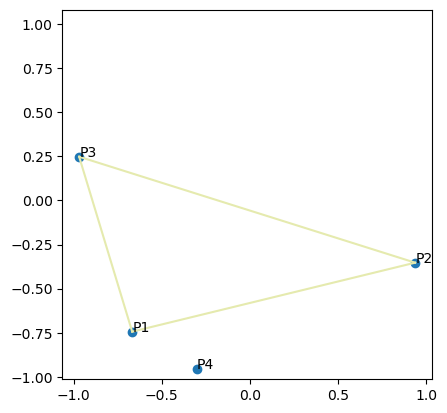

Processing instructions...:   0%|          | 0/3 [00:00<?, ?it/s]

######################## Lines drawn above ########################
['(param (P1 P2 P3) triangle )', '(define P4 point (amidp-same P3 P2 P1))']

INPUT INSTRUCTIONS:
sample (P1 P2 P3) triangle ()
define P4 ((amidp-same P3 P2 P1))
assert (cong P4 P2 P1 P3)


Sampling initializations...: 100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


In [ ]:
num_steps = 3
num_eval = 0
max_eval_attempt = round(math.sqrt(100))
readers, figs = generate_graph(args, num_steps, num_eval, max_eval_attempt=max_eval_attempt)

In [18]:
figs

[[Diagram(named_points={<primitives.Point object at 0x00000210A083AE20>: TfPoint(x=-0.6629814187613037, y=0.7486358516510206), <primitives.Point object at 0x000002109FF13310>: TfPoint(x=0.023342038474394932, y=-0.9997275375020235), <primitives.Point object at 0x000002109FF13130>: TfPoint(x=0.9772952904416322, y=0.21188184273459046)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-0.6629814187613037, y=0.7486358516510206), TfPoint(x=0.023342038474394932, y=-0.9997275375020235)), (TfPoint(x=0.023342038474394932, y=-0.9997275375020235), TfPoint(x=0.9772952904416322, y=0.21188184273459046)), (TfPoint(x=0.9772952904416322, y=0.21188184273459046), TfPoint(x=-0.6629814187613037, y=0.7486358516510206))], seg_colors=[array([0.05907913, 0.67603374, 0.56098859]), array([0.05907913, 0.67603374, 0.56098859]), array([0.05907913, 0.67603374, 0.56098859])], unnamed_points=[], unnamed_lines=[], unnamed_circles=[], ndgs={}, goals={})],
 [Diagram(named_points={<primitives.Point object at 0x00000

In [20]:
for item in readers:
    print(item)

    for pr_item in item.problem_lines:
        print(pr_item)
    print('')

(param (P1 P2 P3) triangle )
(define P4 point (amidp-same P2 P3 P1))

(param (P1 P2 P3) triangle )
(define P4 point (amidp-same P2 P3 P1))

(param (P1 P2 P3) triangle )
(define P4 point (amidp-same P2 P3 P1))
(param P5 point (on-seg P3 P4))
(eval (coll P2 P5 P3))

(param (P1 P2 P3) triangle )
(define P4 point (amidp-same P2 P3 P1))
(param P5 point (on-seg P3 P4))
(eval (cong P1 P5 P3 P2))



Processing instructions...:   0%|          | 0/4 [00:00<?, ?it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3) triangle ()
define P4 ((amidp-same P2 P3 P1))
parameterize P5 (on-seg P3 P4)
eval (cong P1 P5 P3 P2)


Processing instructions...: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]




Found 1 models


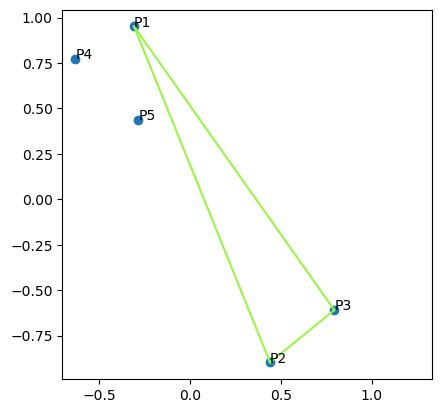

In [21]:
#lines = ['(param (P1 P2 P3) triangle )', '(param (P4 P5 P6) (acute-iso-tri P4) )', '(param (P7 P8 P9) triangle )', '(eval (= P8 P7))']

lines = readers[-1].problem_lines
reader = InstructionReader(lines)
fig = solve_draw(args, reader)

In [ ]:
figs

[[Diagram(named_points={<primitives.Point object at 0x000001751EE14E20>: TfPoint(x=-2.0, y=0.0), <primitives.Point object at 0x000001751EE148E0>: TfPoint(x=-0.8270414499588052, y=1.8209894123937231), <primitives.Point object at 0x000001751EE143D0>: TfPoint(x=2.0, y=0.0)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-2.0, y=0.0), TfPoint(x=-0.8270414499588052, y=1.8209894123937231)), (TfPoint(x=-0.8270414499588052, y=1.8209894123937231), TfPoint(x=2.0, y=0.0)), (TfPoint(x=2.0, y=0.0), TfPoint(x=-2.0, y=0.0))], seg_colors=[array([0.68277867, 0.84928919, 0.06397829]), array([0.68277867, 0.84928919, 0.06397829]), array([0.68277867, 0.84928919, 0.06397829]), array([0.73550185, 0.60529388, 0.20427833]), array([0.73550185, 0.60529388, 0.20427833]), array([0.73550185, 0.60529388, 0.20427833])], unnamed_points=[], unnamed_lines=[], unnamed_circles=[], ndgs={}, goals={})],
 [Diagram(named_points={<primitives.Point object at 0x000001752AF316A0>: TfPoint(x=-2.0, y=0.0), <primitives.Poin